In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Function to minimize
def rosenbrock(v):
    x, y = v[0], v[1]
    return (1 - x)**2 + 100 * (y - x**2)**2

# Gradient descent optimizer
def minimize_rosenbrock(lr=1e-3, steps=1000, init=(0.0, 0.0)):
    x = torch.tensor(init, dtype=torch.float32, requires_grad=True)
    trajectory = [x.detach().numpy().copy()]
    
    for _ in range(steps):
        loss = rosenbrock(x)
        loss.backward()  # Computes the gradient using autograd, stores it in x.grad
        with torch.no_grad():
            x -= lr * x.grad  # Step down the gradient
        x.grad.zero_()  # Don't accumulate the gradient
        trajectory.append(x.detach().numpy().copy())
        
    return np.array(trajectory), x.detach().numpy(), loss.item()

# Newton optimizer
def newton_rosenbrock(init=(0.0, 0.0), steps=20):
    x = torch.tensor(init, dtype=torch.float32, requires_grad=True)
    trajectory = [x.detach().numpy().copy()]
    
    for _ in range(steps):
        f = rosenbrock(x)
        grad = torch.autograd.grad(f, x, create_graph=True)[0]
        
        # Compute Hessian manually
        hessian = []
        for g in grad:
            h_row = torch.autograd.grad(g, x, retain_graph=True)[0]
            hessian.append(h_row)
        H = torch.stack(hessian)

        # Solve H delta = grad (Newton step)
        try:
            delta = torch.linalg.solve(H, grad)  # This solves H*delta = g. delta will thus be (H^-1)*g
        except RuntimeError as e:
            print("Hessian not invertible, stopping.")
            break

        with torch.no_grad():
            x -= delta
        x.requires_grad_(True)
        trajectory.append(x.detach().numpy().copy())

    return np.array(trajectory), x.detach().numpy(), f.item()

# Plot heatmap and trajectory
def plot_optimization_trajectory(traj):
    xgrid = np.linspace(-4, 4, 400)
    ygrid = np.linspace(-4, 4, 400)
    X, Y = np.meshgrid(xgrid, ygrid)
    Z = (1 - X)**2 + 100 * (Y - X**2)**2

    plt.figure(figsize=(8, 6))
    plt.contourf(X, Y, np.log(Z + 1), levels=50, cmap="viridis")
    plt.colorbar(label="log(f(x, y))")
    
    plt.plot(traj[:, 0], traj[:, 1], 'w.-', label="Trajectory", linewidth=1.5, markersize=3)
    plt.scatter([1], [1], c='red', marker='*', s=100, label="Minimum")
    plt.title("Optimization of the Rosenbrock Function")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.grid(True)
    plt.show()


Final point: [0.99234456 0.9847169 ], Loss: 5.8748e-05


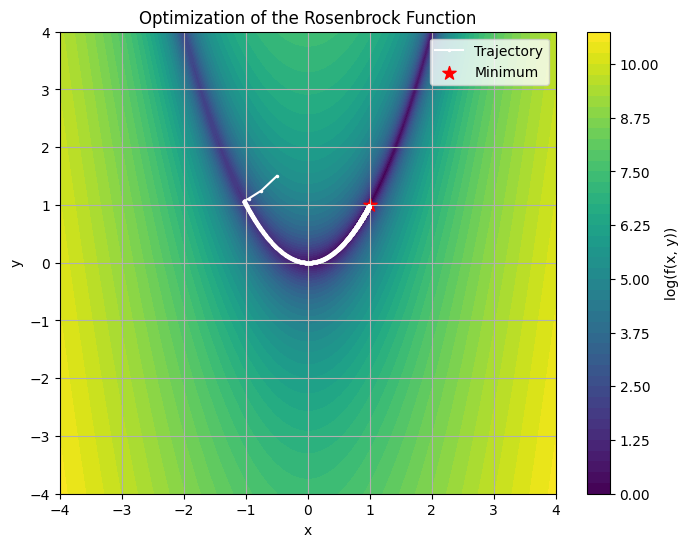

In [45]:
trajectory, final_point, final_loss = minimize_rosenbrock(lr=1e-3, steps=10000, init=(-0.5, 1.5))
print(f"Final point: {final_point}, Loss: {final_loss:.4e}")
plot_optimization_trajectory(trajectory)


Final point: [1. 1.], Loss: 0.0000e+00


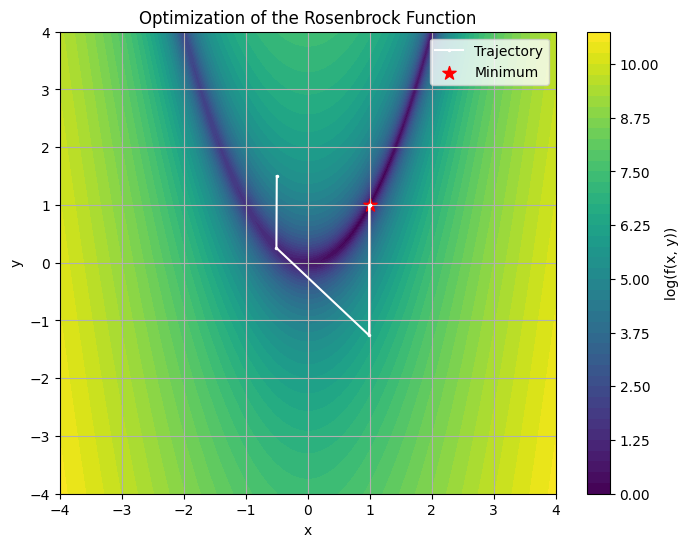

In [49]:
trajectory, final_point, final_loss = newton_rosenbrock(init=(-0.5, 1.5), steps=6)
print(f"Final point: {final_point}, Loss: {final_loss:.4e}")
plot_optimization_trajectory(trajectory)


In [ ]:
# Instead of manually implementing newton, I can just use scipy.optimize
# BFGS is a quasi-newton method. This means that instead of computing the Hessian
# exactly, which is expensive, it constructs an approximation to the Hessian over
# iterations of the optimization.

def rosenbrock_numpy(x):
    return (1 - x[0])**2 + 100 * (x[1] - x[0]**2)**2

from scipy.optimize import minimize
res = minimize(rosenbrock_numpy, x0=[-1.5, 1.5], method='BFGS')
print(res.x)       # final point
print(res.success) # whether it converged

[0.99999547 0.9999909 ]
True
